# TI Calculation


## Imports

In [1]:
#for analysis
from matplotlib import pyplot as plt
%matplotlib inline

import os
import numpy as np
import pygromos
from pygromos.files.gromos_system import Gromos_System
from pygromos.hpc_queuing.submission_systems.local import LOCAL as subSystem
from pygromos.files.blocks.imd_blocks import PERTURBATION, WRITETRAJ

from pygromos.utils import bash

## Input files

In [2]:
root_dir = os.path.abspath(os.path.dirname(pygromos.__file__)+"/../examples/example_files/TI_Calculation")
root_in_dir = root_dir+"/TI_input"
cnf_path = root_in_dir+"/M030_6KET.cnf"
top_path = root_in_dir + "/M030_6KET.top"
disres_path = root_in_dir+"/M030_6KET.disres"


sys_name = "M030_to_6KET"
lam = 0

project_dir = bash.make_folder(root_dir+"/"+sys_name)
input_dir = bash.make_folder(project_dir+"/input")

## Vacuum Simulation

### Direction A->B

#### Setup:


##### Build pertubation file


In [3]:
from pygromos.files.topology.ptp import Pertubation_topology
from pygromos.files.blocks.topology_blocks import pertubation_lam_state, atom_lam_pertubation_state, PERTATOMPARAM, TITLE


#External imd_changes:
grom_system = Gromos_System(in_cnf_path=cnf_path, in_top_path=top_path,
                            in_disres_path=disres_path,
                            system_name=sys_name, work_folder=input_dir)


#Build up lambda - States
pert_atoms=[]
for atom_line in grom_system.top.SOLUTEATOM:
    states = {}
    phys_state = pertubation_lam_state(IAC=atom_line.IAC, MASS=atom_line.MASS, CHARGE=atom_line.CG)
    states = {atom_line.MRES: phys_state }

    pert_atom = atom_lam_pertubation_state(atom_line.ATNM,RES=atom_line.MRES,NAME=atom_line.PANM, STATES=states)
    pert_atoms.append(pert_atom)
pert_atom_block = PERTATOMPARAM(pert_atoms)

# Generate ptp file
grom_system.ptp = Pertubation_topology(in_value = None)
grom_system.ptp.PERTATOMPARAM = pert_atom_block
grom_system.ptp.TITLE = TITLE("Automatic generated pertubation file. ")

grom_system.ptp

TITLE
Automatic generated pertubation file. 
	 >>> Generated with python lib function_libs utilities. (riniker group)
	 >>> line_seperator: '\n'	 field_seperator: '\t'	 comments_char: '#'
END
PERTATOMPARAM
# NJLA  	 NPTB =  	 2 	 
 	 26
# state_identifiers
#  	 state1 	 state2
#    NR   RES  NAME  IAC1mass1   CHARGE1  IAC2mass2   CHARGE2    ALPHLJ     ALPHCRF   
    1     1    C9    16 15.035    0.05200    22 15.035    0.00000    1.00000    1.00000
    2     1    C6    64 12.011    0.21300    22 12.011    0.00000    1.00000    1.00000
    3     1    C2    64 12.011   -0.43400    22 12.011    0.00000    1.00000    1.00000
    4     1    H2    20 1.008    0.16900    22 1.008    0.00000    1.00000    1.00000
    5     1    C4    64 12.011    0.21300    22 12.011    0.00000    1.00000    1.00000
    6     1    C7    16 15.035    0.05200    22 15.035    0.00000    1.00000    1.00000
    7     1    C1    64 12.011   -0.43400    22 12.011    0.00000    1.00000    1.00000
    8     1    H1    

In [4]:
##Write out all generated files
grom_system.rebase_files()

##save Input System
grom_system.save(root_dir+"/initial_startSys.obj")
grom_system

/home/bschroed/Documents/code/pygromos/pygromos/files/gromos_system/gromos_system.py:555: UserWarning: Did not change file path as its only promised None
  if(self.verbose or True): warnings.warn("Did not change file path as its only promised "+str(file_obj.path))
/home/bschroed/Documents/code/pygromos/pygromos/files/gromos_system/gromos_system.py:783: UserWarning: FOUND ALREADY A FILE! SKIPPING!
  warnings.warn("FOUND ALREADY A FILE! SKIPPING!")


File imd is empty , can not be written!



GROMOS SYSTEM: M030_to_6KET
################################################################################
WORKDIR: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/input
LAST CHECKPOINT: None

FILES: 
	imd: None
	top: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/input/M030_to_6KET.top
	cnf: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/input/M030_to_6KET.cnf
	disres: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/input/M030_to_6KET.disres
	ptp: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/input/M030_to_6KET.ptp
GromosXX_bin: None
GromosPP_bin: None
FUTURE PROMISE: False

SYSTEM: 
	Solute:	['M030', '6KET']  resID: [1, 2]  natoms: 26
	SOLVENT:	[]  nmolecules: 0  natoms: 0



### RUN Emin

In [5]:
# PREPARE EMIN
## IMPORT
from pygromos.data.simulation_parameters_templates import template_emin_vac
from pygromos.simulations.modules.preset_simulation_modules import emin

grom_system = Gromos_System.load(root_dir+"/initial_startSys.obj")
step_name  = "a_emin" #also the dir_name, out prefix etc.
grom_system.imd = template_emin_vac #read template imd

#Pertubation for molecules to sim params
pert_block  =  PERTURBATION(NTG=1, NRDGL=0, RLAM=lam, DLAMT=0,
                            ALPHC=0.5, ALPHLJ=0.5, NLAM=2, NSCALE=0)
grom_system.imd.add_block(block=pert_block)

#save checkpoint system
step_dir = project_dir+"/"+step_name


In [6]:
#EXECUTE EMIN
emin_gromos_system, jobID = emin(in_gromos_system=grom_system, project_dir=project_dir,
                          step_name=step_name, submission_system=subSystem(), in_imd_path=None)

emin_gromos_system.save(step_dir+"/emin_out.obj")
emin_gromos_system

################################################################################

a_emin
################################################################################

Script:  /home/bschroed/Documents/code/pygromos/pygromos/hpc_queuing/job_scheduling/schedulers/simulation_scheduler.py
################################################################################
Simulation PREPERATION
################################################################################



################################################################################
Simulation Setup:
################################################################################

steps_per_run:  3000
equis:  0
simulation runs:  1

ChainSubmission - a_emin


 submit  a_emin_1
________________________________________

		 NOT SUBMITTED!(inScript) as these Files were found: 
	/home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/a_emin/simulation/a_emin_1/a_emin*.cnf
################

/home/bschroed/Documents/code/pygromos/pygromos/hpc_queuing/submission_systems/Submission_Systems.py:646: UserWarning: Queue search was called, but no queue present!
  warnings.warn("Queue search was called, but no queue present!")
Traceback (most recent call last):
  File "/home/bschroed/Documents/code/pygromos/pygromos/hpc_queuing/submission_systems/Submission_Systems.py", line 558, in submit_to_queue
    process = bash.execute(command=command, catch_STD=True)
  File "/home/bschroed/Documents/code/pygromos/pygromos/utils/bash.py", line 805, in execute
    return execute_subprocess(command=command, verbose=verbose, catch_STD=catch_STD)
  File "/home/bschroed/Documents/code/pygromos/pygromos/utils/bash.py", line 728, in execute_subprocess
    raise ChildProcessError(msg)
ChildProcessError: SubProcess Failed due to returncode: 1
 COMMAND: 
	python /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/a_emin/job_analysis.py
STDOUT:
	
STDERR:
	b'/home/b


GROMOS SYSTEM: a_emin
################################################################################
WORKDIR: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/a_emin/input
LAST CHECKPOINT: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/initial_startSys.obj

FILES: 
	imd: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/a_emin/input/a_emin.imd
	top: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/a_emin/input/a_emin.top
	cnf: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/a_emin/analysis/data/a_emin.cnf
	disres: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/a_emin/input/a_emin.disres
	ptp: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/a_emin/input/a_emin.ptp
GromosXX_bin: None
GromosPP_bin: None
FUTURE P

## RUN Test SD EQ

In [7]:
from pygromos.data.simulation_parameters_templates import template_sd
from pygromos.simulations.modules.preset_simulation_modules import sd

grom_system = Gromos_System.load(root_dir+"/M030_to_6KET/a_emin/emin_out.obj")
step_name  = "b_vacuum_sd"
grom_system.imd = template_sd

#Pertubation
pert_block  =  PERTURBATION(NTG=1, NRDGL=0, RLAM=lam, DLAMT=0,
                            ALPHC=0.5, ALPHLJ=0.5, NLAM=2, NSCALE=0)
grom_system.imd.add_block(block=pert_block)

#write out trajs:
write_traj = WRITETRAJ(NTWX=100, NTWE=100)
grom_system.imd.add_block(block=write_traj)
step_dir = project_dir+"/"+step_name

#further mods:
grom_system.imd.CONSTRAINT.NTC = 3
grom_system.imd.FORCE.BONDS = 0

grom_system.imd.COVALENTFORM.NTBAH = 0
grom_system.imd.COVALENTFORM.NTBDN = 0
grom_system.imd.COVALENTFORM.NTBBH = 0

grom_system.imd.STEP.NSTLIM = 30000




In [8]:
sd_gromos_system, jobID  = sd(in_gromos_system=emin_gromos_system, project_dir=project_dir,
                              step_name=step_name, submission_system=subSystem(),
                      equilibration_runs=1, simulation_runs=1)
sd_gromos_system.save(step_dir+"/sd_out_system.obj")
sd_gromos_system

################################################################################

b_vacuum_sd
################################################################################

FOUND RESULT: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/b_vacuum_sd/analysis/data/b_vacuum_sd.cnf
 GOING TO SKIPT THIS SUBMISSION!



GROMOS SYSTEM: b_vacuum_sd
################################################################################
WORKDIR: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/b_vacuum_sd/input
LAST CHECKPOINT: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/a_emin/emin_out.obj

FILES: 
	imd: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/b_vacuum_sd/input/b_vacuum_sd.imd
	top: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/b_vacuum_sd/input/b_vacuum_sd.top
	cnf: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/b_vacuum_sd/analysis/data/b_vacuum_sd.cnf
	disres: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/b_vacuum_sd/input/b_vacuum_sd.disres
	ptp: /home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/b_vacuum

## Further Analysis:
Transform the trc into a pdb traj to check it out with pymol :!)

In [9]:
#final analysis dir:
from pygromos.utils import bash

out_ana = project_dir+"/c_ana"
if(not os.path.exists(out_ana)):
    bash.make_folder(out_ana)

In [10]:
from pygromos.files.coord import Cnf
in_path=project_dir+"/a_emin/analysis/data/a_emin.cnf"
cnf_file = Cnf(in_path)
cnf_file.write_pdb(in_path.replace("cnf", "pdb"))

'/home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/M030_to_6KET/a_emin/analysis/data/a_emin.pdb'

In [11]:
from pygromos.files.trajectory.trc import Trc

in_path=project_dir+"/b_vacuum_sd/analysis/data/b_vacuum_sd.trc.h5"

trc = Trc(input_value=in_path)
trc.write_pdb(out_ana+"/sd_traj.pdb", cnf_file=cnf_path)#grom_system.cnf.path)
trc

Trajectory: 
	Read from hdf save 
	Contains only database
	
Type: 
	Trc
Frames: 	300	 Columns:	28


In [12]:
from pygromos.files.trajectory.tre import Tre

in_path=project_dir+"/b_vacuum_sd/analysis/data/b_vacuum_sd.tre.h5"

tre = Tre(input_value=in_path)
tre



Trajectory: 
	Read from hdf save 
	Contains only database
	
Type: 
	Tre
Frames: 	300	 Columns:	15


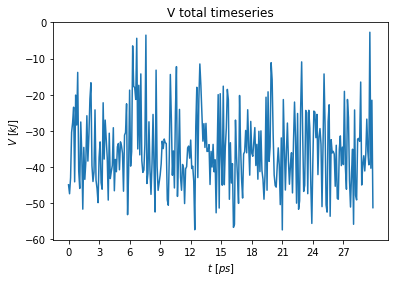

In [13]:
#Plot Potential Energies
V_tot = np.array(list(map(lambda x: x[2], tre.database.totals)))
step = len(tre.database.TIMESTEP_time)//10

plt.plot(tre.database.TIMESTEP_time, V_tot)
plt.xticks(np.round(list(tre.database.TIMESTEP_time[::step]),2))
plt.xlabel("$t~[ps]$")
plt.ylabel("$V~[kJ]$")
plt.title("V total timeseries")
plt.savefig(out_ana+"/potential_energy_timeseries.png")



## Lambda Sampling

### Setup again

In [14]:
import numpy as np
from pygromos.files.gromos_system import Gromos_System
from pygromos.hpc_queuing.submission_systems.local import LOCAL as subSystem

from pygromos.utils import bash
sys_name = "M030_to_6KET"
root_dir = os.path.abspath(os.path.dirname(pygromos.__file__)+"/../examples/example_files/TI_Calculation")

project_dir = bash.make_folder(root_dir+"/"+sys_name)
sys_path = "/home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/6KET_to_M030/b_vacuum_sd/sd_out_system.obj"
sd_gromos_system = Gromos_System.load(sys_path)
sd_gromos_system

FileNotFoundError: [Errno 2] No such file or directory: '/home/bschroed/Documents/code/pygromos/examples/example_files/TI_Calculation/6KET_to_M030/b_vacuum_sd/sd_out_system.obj'

## Submission

In [ ]:
from pygromos.simulations.modules.ti_modules import TI_sampling

step_name  = "d_lambda_sampling"

TI_sampling(in_gromos_system = sd_gromos_system, project_dir=project_dir, step_name  = step_name,
            lambda_values= np.arange(0, 1.1, 0.1),
            subSystem=subSystem(), n_simulation_repetitions = 3, n_equilibrations = 1)


### Direction B->A

#### Setup: